<h2 align=center> Facial Expression Recognition with Keras</h2>

### Task 1: Import Libraries

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot import PlotLossesTensorFlowKeras
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.1.0


### Task 2: Plot Sample Image

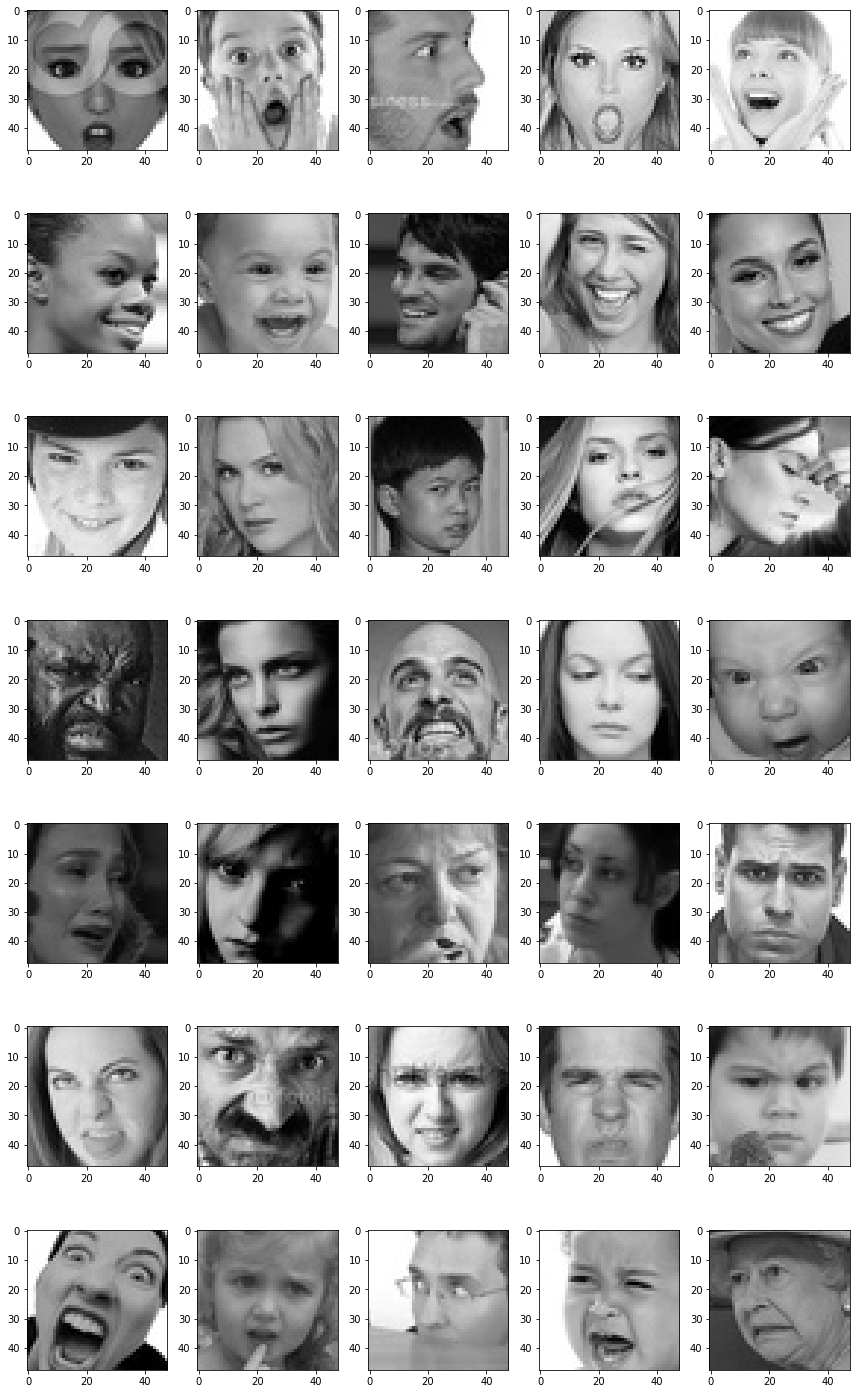

In [2]:
utils.datasets.fer.plot_example_images(plt).show()

In [4]:
for expression in os.listdir("train/"):
    print(str(len(os.listdir("train/" + expression))) + " " + expression + " images")

3171 surprise images
7215 happy images
4965 neutral images
3995 angry images
4830 sad images
436 disgust images
4097 fear images


### Task 3: Generate Training and Validation Batches

In [5]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip=True)

train_generator = datagen_train.flow_from_directory("train/",
                                                   target_size=(img_size, img_size),
                                                   color_mode='grayscale',
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   shuffle=True)

datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_train.flow_from_directory("test/",
                                                   target_size=(img_size, img_size),
                                                   color_mode='grayscale',
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Task 4: Create CNN Model

![](model.png)
Inspired by Goodfellow, I.J., et.al. (2013). Challenged in representation learning: A report of three machine learning contests. *Neural Networks*, 64, 59-63. [doi:10.1016/j.neunet.2014.09.005](https://arxiv.org/pdf/1307.0414.pdf)

In [7]:
model = Sequential()

# 1 - conv
model.add(Conv2D(64, (3,3), padding='same', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 2 - conv
model.add(Conv2D(128, (5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 3 - conv
model.add(Conv2D(512, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 4 - conv
model.add(Conv2D(512, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Output layer
model.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy',
             metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)      

### Visualize Model architecture

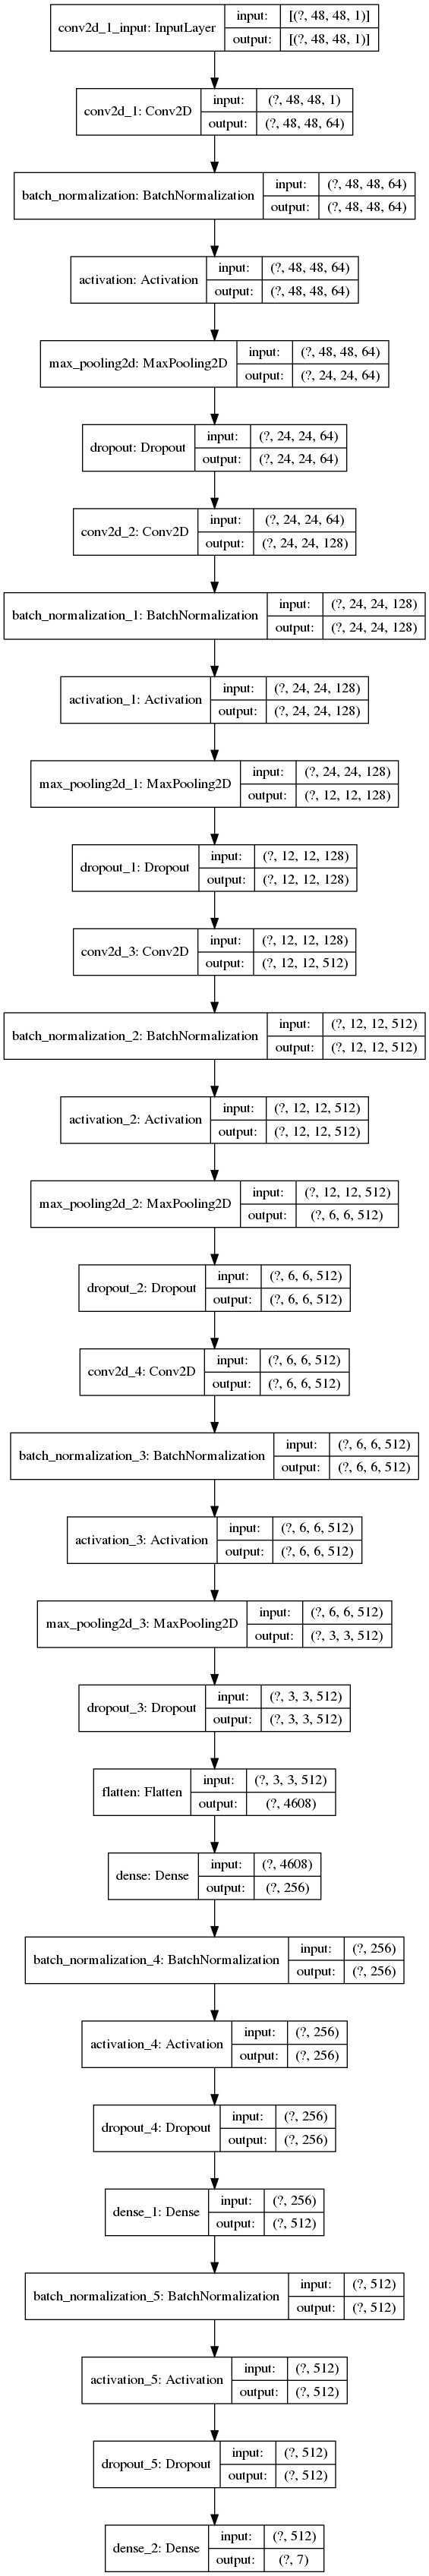

In [8]:
plot_model(model, to_file='fet_model.png', show_shapes=True, show_layer_names=True)
Image('fet_model.png', width=400, height=200)

### Task 5: Train and Evaluate Model

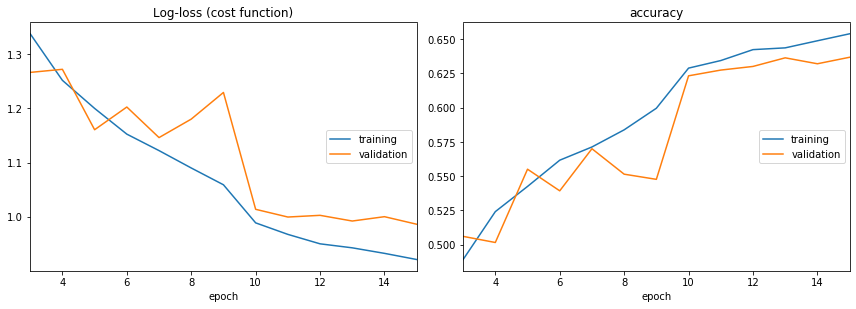

Log-loss (cost function):
training   (min:    0.921, max:    1.807, cur:    0.921)
validation (min:    0.986, max:    2.045, cur:    0.986)

accuracy:
training   (min:    0.306, max:    0.654, cur:    0.654)
validation (min:    0.282, max:    0.637, cur:    0.637)

Epoch 00015: saving model to model_weights.h5
448/448 [==============================] - 28s 61ms/step - loss: 0.9208 - accuracy: 0.6538 - val_loss: 0.9862 - val_accuracy: 0.6367


In [9]:
epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                            save_weights_only=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001,
                             model='auto')
callbacks = [PlotLossesTensorFlowKeras(), checkpoint, reduce_lr]

history = model.fit(x=train_generator,
                   steps_per_epoch=steps_per_epoch,
                   epochs=epochs,
                   validation_data=validation_generator,
                   validation_steps=validation_steps,
                   callbacks=callbacks)

### Task 6: Represent Model as JSON String

In [10]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)